# Recycling Robot MDP – Value Iteration/policy Iteration

This notebook models the **Recycling Robot MDP** as introduced in Sutton & Barto (Example 3.11). We solve the MDP using two classical dynamic programming methods:
- **Value Iteration** (based on Bellman Optimality)
- **Policy Iteration** (based on evaluation & improvement loops)

In [9]:
import numpy as np
import matplotlib.pyplot as plt

### Transition Graph
<img src = "./pictures/1.png"/>

### 1. MDP Parameters and State/Action Definitions

We define a 2-state MDP:
- **high** (battery is charged)
- **low** (battery is low)

Available actions:
- **search**: try to find recyclable material (risky in `low`)
- **wait**: do nothing and stay
- **recharge**: only available in `low` to transition to `high`

We also define transition probabilities:
- `α`: P(stay in high | high, search)
- `β`: P(go to high | low, search)


<img src = "./pictures/2.png"/>

In [10]:


# MDP Parameters
alpha = 0.8
beta = 0.2
r_search = 1.0
r_wait = 0.2
r_fail = -3.0
gamma = 0.9

states = ["high", "low"]
actions = ["search", "wait", "recharge"]
available_actions = {
    0: [0, 1],        # high: search, wait
    1: [0, 1, 2]      # low: search, wait, recharge
}

### 2. Transition and Reward Matrices

This cell encodes the transition probability \( P(s' \mid s,a) \) and immediate reward \( R(s,a,s') \) functions.

For example:
- `P[0,0,1]` = \( 1 - \alpha \): transition from `high` to `low` when searching.
- `R[1,0,1]` = reward for searching in `low` and staying.

Battery failure in state `low` during `search` is modeled **manually** by incorporating the penalty in value updates.


In [11]:
# Transition and Reward Matrices
P = np.zeros((2, 3, 2))
R = np.zeros((2, 3, 2))

# State: high (0)
P[0, 0, 0] = alpha
P[0, 0, 1] = 1 - alpha
R[0, 0, :] = r_search

P[0, 1, 0] = 1
R[0, 1, 0] = r_wait

# State: low (1)
P[1, 0, 0] = beta  # successful search: go to high
R[1, 0, 1] = r_search  # reward for remaining in low
P[1, 1, 1] = 1
R[1, 1, 1] = r_wait
P[1, 2, 0] = 1  # recharge leads to high

### 3. Value Iteration – Bellman Optimality

We implement the **Bellman update**:

$
V_{k+1}(s) = \max_a \sum_{s'} P(s' \mid s, a) \left[ R(s,a,s') + \gamma V_k(s') \right]
$


This continues until:\
$
\max_s |V_{k+1}(s) - V_k(s)| < \theta
$

The loop converges to the optimal value function \( V^* \), and we extract the optimal policy greedily.


<img src="./pictures/3.png"/>

In [12]:
# Value Iteration
V = np.zeros(2)
theta = 1e-8
history_vi = [V.copy()]

for _ in range(1000):
    delta = 0
    V_new = V.copy()
    for s in range(2):
        values = []
        for a in available_actions[s]:
            if s == 1 and a == 0:  # low battery and search
                value = beta * (r_search + gamma * V[1]) + (1 - beta) * (r_fail + gamma * V[0])
            else:
                value = sum(P[s, a, s2] * (R[s, a, s2] + gamma * V[s2]) for s2 in range(2))
            values.append(value)
        V_new[s] = max(values)
        delta = max(delta, abs(V[s] - V_new[s]))
    V = V_new
    history_vi.append(V.copy())
    if delta < theta:
        break

### 4. Extract Optimal Policy from Value Function

Once $( V^* )$ converges, the optimal policy $( \pi^*(s) )$ is obtained by:

$
\pi^*(s) = \arg\max_a \sum_{s'} P(s' \mid s,a) \left[ R(s,a,s') + \gamma V^*(s') \right]
$

We store the best action for each state using the final value function.


In [13]:
# Optimal Policy from Value Iteration
policy_vi = np.zeros(2, dtype=int)
for s in range(2):
    values = []
    for a in available_actions[s]:
        if s == 1 and a == 0:
            value = beta * (r_search + gamma * V[1]) + (1 - beta) * (r_fail + gamma * V[0])
        else:
            value = sum(P[s, a, s2] * (R[s, a, s2] + gamma * V[s2]) for s2 in range(2))
        values.append(value)
    policy_vi[s] = available_actions[s][np.argmax(values)]

V(high) = 8.474576
V(low) = 7.627119
π(high) = search
π(low) = recharge


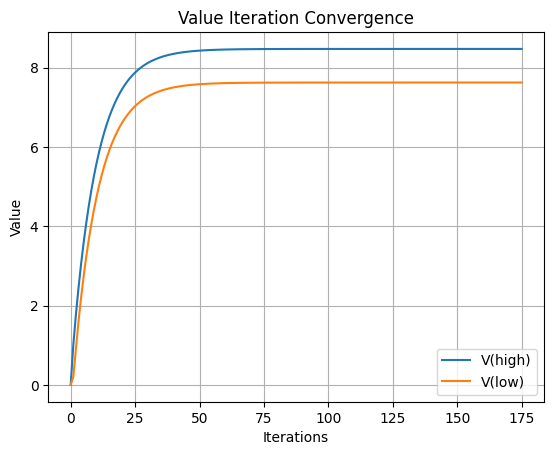

In [14]:
# Display Results
for s in range(2):
    print(f"V({states[s]}) = {V[s]:.6f}")
for s in range(2):
    print(f"π({states[s]}) = {actions[policy_vi[s]]}")

# Plot Value Iteration Convergence
plt.figure()
plt.plot([v[0] for v in history_vi], label="V(high)")
plt.plot([v[1] for v in history_vi], label="V(low)")
plt.xlabel("Iterations")
plt.ylabel("Value")
plt.title("Value Iteration Convergence")
plt.legend()
plt.grid(True)
plt.show()

### 5. Policy Iteration – Evaluation & Improvement

Policy Iteration follows this loop:

1. **Policy Evaluation**:\
$
V^\pi(s) = \sum_{s'} P(s' \mid s, \pi(s)) \left[ R(s,\pi(s),s') + \gamma V^\pi(s') \right]
$

2. **Policy Improvement**:\
$
\pi_{\text{new}}(s) = \arg\max_a \sum_{s'} P(s' \mid s,a) \left[ R(s,a,s') + \gamma V^\pi(s') \right]
$

Repeat until the policy no longer changes (stable).


In [15]:
# Policy Iteration
def policy_evaluation(policy, theta=1e-20, max_iterations=10000):
    V_pi = np.zeros(2)
    for _ in range(max_iterations):
        delta = 0
        for s in range(2):
            v = V_pi[s]
            a = policy[s]
            if s == 1 and a == 0:
                V_pi[s] = beta * (r_search + gamma * V_pi[1]) + (1 - beta) * (r_fail + gamma * V_pi[0])
            else:
                V_pi[s] = sum(P[s, a, s2] * (R[s, a, s2] + gamma * V_pi[s2]) for s2 in range(2))
            delta = max(delta, abs(v - V_pi[s]))
        if delta < theta:
            break
    return V_pi

# Initialize policy randomly
policy_pi = np.zeros(2, dtype=int)
for s in range(2):
    policy_pi[s] = np.random.choice(available_actions[s])

history_pi = []
for _ in range(100):
    V_pi = policy_evaluation(policy_pi)
    history_pi.append(V_pi.copy())
    policy_stable = True
    for s in range(2):
        old_action = policy_pi[s]
        values = []
        for a in available_actions[s]:
            if s == 1 and a == 0:
                value = beta * (r_search + gamma * V_pi[1]) + (1 - beta) * (r_fail + gamma * V_pi[0])
            else:
                value = sum(P[s, a, s2] * (R[s, a, s2] + gamma * V_pi[s2]) for s2 in range(2))
            values.append(value)
        best_action = available_actions[s][np.argmax(values)]
        if old_action != best_action:
            policy_stable = False
        policy_pi[s] = best_action
    if policy_stable:
        break


Policy Iteration Results:
V_pi(high) = 8.474576
V_pi(low) = 7.627119
π_pi(high) = search
π_pi(low) = recharge


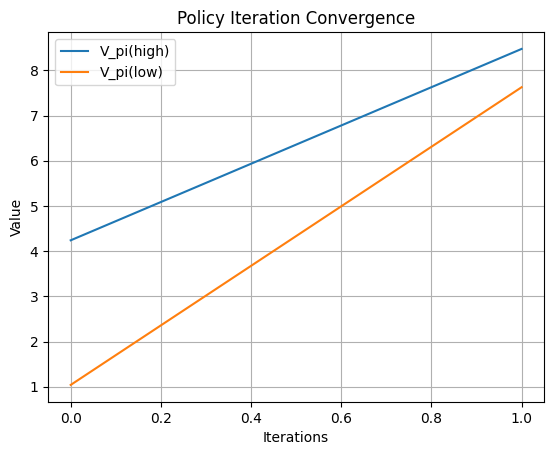

In [16]:
# Display Policy Iteration Results
print("\nPolicy Iteration Results:")
for s in range(2):
    print(f"V_pi({states[s]}) = {V_pi[s]:.6f}")
for s in range(2):
    print(f"π_pi({states[s]}) = {actions[policy_pi[s]]}")

# Plot Policy Iteration Convergence
plt.figure()
plt.plot([v[0] for v in history_pi], label="V_pi(high)")
plt.plot([v[1] for v in history_pi], label="V_pi(low)")
plt.xlabel("Iterations")
plt.ylabel("Value")
plt.title("Policy Iteration Convergence")
plt.legend()
plt.grid(True)
plt.show()